In [58]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import *
import iminuit
from iminuit import Minuit, describe, Struct
from scipy.interpolate import interp1d

sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/Modules/")
sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/")
# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw

# Siddharth and Laura's Stuff
import constants_noh as constants
import units

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
rcParams['font.size'] = 15
rcParams['text.usetex'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Global settings
nside=128
emin = 0
emax = 39

In [60]:
trials = 1000
channel = 'b'
Nb = 2
conc = "SP"
xsec = 1e-25
marr = [100]
ebins = 2*np.logspace(-1,3,41)[emin:emax+2]
my_iebins = [10, 15]
print(ebins[my_iebins])

[2.         6.32455532]


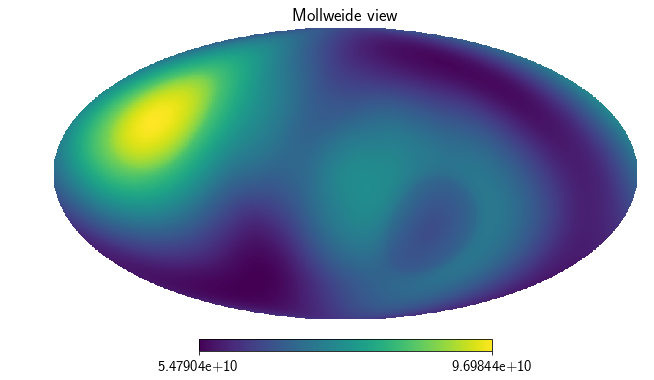

In [61]:
exposure_ebins= []
for ib, b in enumerate(my_iebins[:-1]):
    fermi_exposure = np.zeros(len(np.load("maps/exposure0.npy")))
    n = 0
    for bin_ind in range(b, my_iebins[ib+1]):
        n+=1
        fermi_exposure += np.load("maps/exposure"+str(bin_ind)+".npy")
    fermi_exposure = fermi_exposure / n
    exposure_ebins.append(fermi_exposure)
hp.mollview(fermi_exposure)

In [62]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('/tigress/somalwar/Subhaloes/Subhalos/fermi_data/fermidata_pscmask.npy'), dtype=bool)
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
area_rat = (len(mask[~mask]))/len(mask)

In [63]:
# Defining some constants
r_s = 199 # scale radius, [kpc]
alpha = 0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e12 # [M_s]
mMin_calib = 1e8 # [M_s]
mMax_calib = 1e10 # [M_s]
mMin = 1e-5*M_MW
mMax = .01*M_MW # [M_s]
min_flux_arr = []
for exposure in exposure_ebins:
    min_flux_arr.append(np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask]))))

In [64]:
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)

N_subs = np.random.poisson( round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) ) # Total number of subhalos

m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 8000) # mass values to test
def mCDFInv(r):
    return ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*r)**(-1/.9)

rho_s2 = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, 2000)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

In [65]:
r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_Ein(r), r_arr, nsamples=N_subs)
m_sampler = InverseTransform.InverseTransform(dNdm_func, m_arr, nsamples=N_subs, cdfinv=mCDFInv)

In [66]:
PS_arr_ebins = []
F_arr_ebins = []
PPnoxsec_ebins = []
flux_bins = np.logspace(-15, -6, 8*8)
for ib in range(len(my_iebins)-1):
    PS_arr = []
    F_arr = []
    for i in tqdm_notebook(range(trials)):
        rval_arr = r_sampler.sample()
        mval_arr = m_sampler.sample()

        theta_arr = (np.arccos(2*np.random.rand(N_subs)-1))
        phi_arr = (2*np.pi*np.random.rand(N_subs))

        PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
        PS_set.calcJ(conc)
        PS_arr.append(PS_set)

        if i == 0: 
            PPnoxsec = PS_set.PPnoxsec(marr[0], [ ebins[my_iebins[ib]], ebins[my_iebins[ib+1]] ], channel)
            PPnoxsec_ebins.append(PPnoxsec)
        F_arr.append(np.histogram(PS_set.J.value[~mask[PS_set.pixels]] * xsec * PPnoxsec, bins=flux_bins)[0])
    PS_arr_ebins.append(PS_arr)
    F_arr_ebins.append(F_arr)

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [67]:
tot=0
for PS_set in PS_arr:
    F_arr = PS_set.J.value[~mask[PS_set.pixels]] * xsec * PPnoxsec
    tot += len(F_arr[F_arr > 10**min_flux])
print(tot/len(PS_arr))

1.644


In [ ]:
data = np.load("/tigress/somalwar/Subhaloes/Subhalos/MC/subhalo_flux_map0_10-15.npy")*exposure[0]*1e-25/1e-22
data[data < 1] = 0
print(data[data!=0])
hp.mollview(np.log10(1e-30+data))

In [68]:
min_flux_ind_arr = []
F_ave_arr = []
max_flux_arr = []
dF_arr = []
dN_arr = []
F_arr_arr = []
F_val_arr = []
for ib in range(len(my_iebins)-1):
    min_flux_ind_arr.append(np.argmin(np.abs(flux_bins - 10.**(min_flux_arr[ib]))))
    flux_bins2 = flux_bins[min_flux_ind_arr[-1]:]
    F_arr = np.array(F_arr_ebins[ib]).astype(float)
    for i in range(len(F_arr)):
        F_arr[i][F_arr[i]<=1e-30] = 1e-50
    F_arr_arr.append(F_arr)
    F_ave_arr.append((np.median(F_arr, axis=0))[min_flux_ind_arr[-1]:])
    max_flux_arr.append(np.log10(flux_bins2[np.argmax(F_ave_arr[-1] < 1e-20)]))
    dF_arr.append(np.diff(flux_bins2))
    dN_arr.append(np.array(F_ave_arr[-1])/(4*np.pi*(180/np.pi)**2*area_rat))
    F_val_arr.append((np.array(flux_bins2)[:-1]+np.array(flux_bins2)[1:])/2.)

In [69]:
print("running")
best_fit_params = []
subhalos = np.load('/tigress/somalwar/Subhaloes/Subhalos/MC/EinastoTemplate2.npy')
for ib, PS_arr in enumerate(PS_arr_ebins):
    flux_map_ave = np.zeros(hp.nside2npix(nside))
    for iP, PS_set in (enumerate(PS_arr)):
        flux_map = np.zeros(hp.nside2npix(nside))
        flux = PS_set.J.value * xsec * PPnoxsec_ebins[ib]
        for ipix, pix in enumerate(PS_set.pixels):
            flux_map[pix] += flux[ipix]
            flux_map_ave[pix] += flux[ipix]
        #np.save("/tigress/somalwar/Subhaloes/Subhalos/MC/subhalo_flux_map_alpha17"+str(iP)+"_"+str(my_iebins[ib])+"-"+str(my_iebins[ib+1]), flux_map) 
    n = nptfit.NPTF(tag='fit')
    sig = np.round(flux_map_ave / trials * exposure_ebins[ib]).astype(np.int32)
    n.load_data(sig.copy(), exposure_ebins[ib].copy())
    n.load_mask(mask)
    
    A0 = 5.45252e-06
    n20 = 1.45582
    n10 = 10.0
    print(max_flux_arr[ib])
    Fb0 = 10**(max_flux_arr[ib])*np.average(exposure_ebins[ib][mask]) #10**(-7.71429)*np.average(exposure_ebins[ib][~mask])    

    subhalos_copy = subhalos.copy()
    n.add_template(subhalos_copy, 'subhalos', units='PS')
    n.add_non_poiss_model('subhalos', 
                           #['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$', '$n_3$', '$F_b1$', '$F_b2$'],
                           ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$', '$F_b$'],
                              units='counts')
    n.configure_for_scan(nexp=20);
    
    #minuit_min = iminuit.Minuit(lambda A, n1, n2, n3, Fb1, Fb2: -n.ll([A, n1, n2, n3, Fb1, Fb2]), n1=n10, Fb1=Fb0, fix_n1=True, fix_Fb1=True, fix_A=False, fix_n2=False, fix_n3=False, fix_Fb2=False, A=A0, limit_A=(1e-15, 1), error_A=1e-15, n2=n20, limit_n2=(-3.,3.), error_n2=1e-2, n3=n20, limit_n3=(-3.,3.), error_n3=1e-2, Fb2=Fb0/2., limit_Fb2=(0, Fb0), error_Fb2=1e-2, print_level=1);
    minuit_min = iminuit.Minuit(lambda A, n1, n2, Fb: -n.ll([A, n1, n2, Fb]), n1=n10, Fb=Fb0, fix_n1=True, fix_Fb=True, fix_A=False, fix_n2=False, A=A0, limit_A=(1e-15, 1), error_A=1e-15, n2=n20, limit_n2=(-3.,3.), error_n2=1e-2, print_level=1);
    #minuit_min.migrad()
    max_LL = -minuit_min.fval
    best_fit_params.append( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['Fb'] ]))
    #best_fit_params[-1] = np.array(best_fit_params[-1]*np.array([np.average(exposure_ebins[ib][~mask]/area_rat/(4*np.pi * (180/np.pi)**2)*np.sum(subhalos[~mask])), 1., 1., 1/np.average(exposure_ebins[ib][~mask])]))
    best_fit_params[-1][0] = np.log10(best_fit_params[-1][0])
    best_fit_params[-1][3] = np.log10(best_fit_params[-1][3])
    print("Best Fit Params:", best_fit_params)
    print("Max LL:", max_LL)

running
-10.857142857142858
The number of parameters to be fit is 4
Best Fit Params: [array([-5.26340273e+00,  1.00000000e+01,  1.45582000e+00, -8.75466716e-03])]
Max LL: -0.0


/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: InitialParamWarning: errordef is not given. Default to 1.


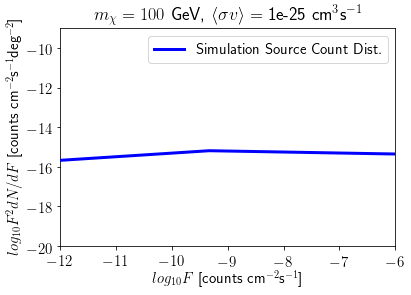

In [70]:
best_fit_params = [np.array([ 9.179840536033368e-07, 2.050000262756742, 1.815918618123412, 0.11157967083824684, 29.997010274239567, 0.15555250541844035])]
for ib, F_arr in enumerate(F_arr_arr):
    F_ave = F_ave_arr[ib]
    max_flux = max_flux_arr[ib]
    min_flux = min_flux_arr[ib]
    dF = dF_arr[ib]
    dN = dN_arr[ib]
    F = F_val_arr[ib]
    min_flux_ind = min_flux_ind_arr[ib]
    poisson = (trials==1)
    yerr_up = (AssortedFunctions.PandGErrors(F_arr, poisson))[1][min_flux_ind:]
    yerr_dn = (AssortedFunctions.PandGErrors(F_arr, poisson))[0][min_flux_ind:]
    yerr_up = F**2 * yerr_up / dF /(4*np.pi*(180/np.pi)**2*area_rat)
    yerr_dn = F**2 * yerr_dn / dF /(4*np.pi*(180/np.pi)**2*area_rat)
    
    yerr_up = yerr_up/np.log(10) / (F**2 * dN/dF)
    yerr_dn = yerr_dn/np.log(10) / (F**2 * dN/dF)
    plt.errorbar(myLog(F), myLog(F**2*dN/dF), yerr=[yerr_up, yerr_dn], fmt='o', c="black")
    F_test = np.logspace(-12,6,5000)
    best_fit_params2 = best_fit_params[ib]
    #best_fit_params2[0] = 10**best_fit_params2[0]
    #best_fit_params2[3] = 10**best_fit_params2[3]
    best_fit_params2 = np.array(best_fit_params2*np.array([np.average(exposure_ebins[ib][~mask]/area_rat/(4*np.pi * (180/np.pi)**2)*np.sum(subhalos[~mask])), 1., 1., 1., 1/np.average(exposure_ebins[ib][~mask]), 1/np.average(exposure_ebins[ib][~mask])]))
    best_fit_params2[0] = np.log10(best_fit_params2[0])
    best_fit_params2[-2:] = np.log10(best_fit_params2[-2:])
    best_fit_params2[-1] = best_fit_params2[-1] + best_fit_params2[-2]
    plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params2), zorder=5, linewidth=3, c="blue", label="Simulation Source Count Dist.") #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))

    plt.xlim(-12, -6)
    plt.ylim(-20, -9)
    plt.title("$m_{\chi} = "+str(marr[0])+"$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
    plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
    plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
    plt.legend()
    plt.show()
    plt.close()